# The GSW Dataset

We use the estimates of the US treasury yield curve provided by the Fed in the well-known [GSW dataset](https://www.federalreserve.gov/data/nominal-yield-curve.htm). The dataset is named after its creators Refet S. Gurkaynak, Brian P. Sack, and Jonathan H. Wright, who published a paper in 2006 titled "The U.S. Treasury Yield Curve: 1961 to the Present" to introduce the methodology and the dataset. It is widely used by researchers, market practitioners, and policymakers for analyzing the term structure of interest rates and their evolution over time.

The GSW dataset is based on a parametric yield curve model, specifically an extended version of the Nelson-Siegel model, also called the Svensson model. The GSW yield curve estimates are constructed using a large set of U.S. Treasury securities with varying maturities. The model aims to provide a smooth, continuous representation of the yield curve while minimizing the differences between the model-implied and observed yields for the Treasury securities.

The GSW dataset includes daily estimates of the zero-coupon yield curve for U.S. Treasury securities. The dataset provides yield estimates for a range of maturities, from 3 months to 30 years, and covers a long historical period starting in 1961.


# The Svensson Model

The Svensson model, also known as the extended Nelson-Siegel model, is a parametric model used to estimate and represent the term structure of interest rates or the yield curve. It was introduced by Lars E.O. Svensson in 1994 as an extension of the earlier Nelson-Siegel model. The Svensson model aims to provide a smooth, continuous representation of the yield curve while minimizing the differences between the model-implied yields and the observed yields for a set of fixed income securities.Below is the Svensson model of yields:

$$ f(t, t+m) = \beta_0 + \beta_1exp(-\frac{m}{\tau_1}) + \beta_2\frac{m}{\tau_1}exp(-\frac{m}{\tau_1}) + \beta_3\frac{m}{\tau_2}exp(-\frac{m}{\tau_2})$$

Note that all parameters in the model are reported in the [GSW dataset](https://www.federalreserve.gov/data/nominal-yield-curve.htm). The Svensson model uses a four-component functional form to represent the yield curve. These components include: a constant term representing the long-term level of interest rates $\beta_0$; a decaying term representing the slope of the yield curve $\beta_1exp(-\frac{m}{\tau_1})$; two exponential terms representing the curvature and a second hump or inflection point in the yield curve, which is $\beta_2\frac{m}{\tau_1}exp(-\frac{m}{\tau_1}) + \beta_3\frac{m}{\tau_2}exp(-\frac{m}{\tau_2})$








# Data Parsing

We use the load_gsw function to load and convert data from the GWS dataset into the Svensson model estimates of yields as well as corrresponding maturities. Using the YTM data, we compute the prices of Zero Bonds, before obtaining the excess log return of Zero Bonds for each maturities on each date.

In [1501]:
import pandas as pd
import numpy as np
from pandas.tseries.offsets import *
from datetime import datetime

def load_gsw(filename: str, n_maturities: int): # Load GSW dataset.               
  
  data = pd.read_csv(filename)
  for i in range(len(data['Date'])):
    data.iloc[i, 0] = datetime.strptime(data.iloc[i, 0], '%m/%d/%Y') # parse strings in 'Date' column and turn it into datetime object

  data = data.set_index(data['Date']) # set date as index 
  data.index = pd.to_datetime(data.index)
  data = data.resample('BM').last() # use the last data in each month as proxy for the month's data 
  data.index = pd.to_datetime(data.index)
  data.index = data.index + DateOffset() # move index forward by one day so that it becomes the first business day of the month
  plot_dates = pd.to_datetime(data['Date']) # create the 'plot_data' output in type of datetime for matpoltlib plotting

  Beta0 = data['BETA0']
  Beta1 = data['BETA1']
  Beta2 = data['BETA2']
  Beta3 = data['BETA3']
  Tau1  = data['TAU1']
  Tau2  = data['TAU2']

  def nss_yield(m): # Nelson, Svensson, Siegel yield curve parameterization
    return Beta0 + Beta1 * (1 - np.exp(-m / Tau1)) / (m / Tau1) + \
        Beta2 * ((1 - np.exp(-m/Tau1))/(m/Tau1) - np.exp(-m/Tau1)) + \
        Beta3 * ((1 - np.exp(-m/Tau2))/(m/Tau2) - np.exp(-m/Tau2))

  # Compute yields
  # rawYields is a n-dimensional array with nrow = data.shape[0] and ncol = n_maturities
  # n_maturities is in the unit of months
  rawYields = np.ndarray(shape=(data.shape[0], n_maturities))

  for maturity in range(0, n_maturities):
      rawYields[:, maturity] = nss_yield((maturity+1)/12.0)

  # the output of the function
  # piecewise constant forward rates for month intervals from month #1 till month #120
  # which are estimated by the Svensson model using paramters estimated by the Fed
  # provided in the GSW dataset 
  return rawYields, plot_dates 


In [1502]:
# Demonstrates the Adrian, Crump and Moench (2013) term structure estimation procedure.
# This procedure allows instantaneous estimation of an affine term structure model.


import pandas as p
import numpy as np
from numpy import newaxis
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import matplotlib.dates as mdates


# User-specified options.
# Compute yields and excess returns for maturities up to 10 years / 120 months.
n_maturities = 120  
# Use five factors (i.e. five principal components of yields)
K = 5  
# Use excess returns at these maturities to estimate the model.
rx_maturities = (6, 18, 24, 36, 48, 60, 84, 120) 


# Helper functions
def vec(x):
    return np.reshape(x, (-1, 1))
def vec_quad_form(x):
    return vec(np.outer(x, x))

In [1503]:
# from google.colab import drive
# drive.mount('/content/drive')
# %cd /content/drive/MyDrive/728project

In [1504]:
rawYields, plot_dates = load_gsw('C:\\Users\\邹竟翔\\Desktop\\728gogogo\\feds200628.csv', n_maturities) # please beware that rawYields in the unit of percent
# rawYields = 0.01 * rawYields
# we need to use the discrepency of logprices to get rate shifts
# that leaves us with (rawYields.shape[0] - 1) observations 
t = rawYields.shape[0] - 1

# Compute log excess returns from continuously compounded yields
ttm = np.arange(1.0, n_maturities + 1.0)[newaxis, :] / 12.0 # time to maturity, in unit of years, from 1 mon till 10 years
# the np.arrange function creates a one dimensional array, while the newaxis keyword creates a new dimension so that the data becomes a 2 dim matrix in the dims of (1, n_maturities)
logPrices = - rawYields * ttm
# the risk free rate equals the 1-month rate 
rf = -logPrices[:-1, [0]] # number of observations set to equal t
rx = logPrices[1:, :-1] - logPrices[:-1, 1:] - rf

In [1505]:
pd.DataFrame(ttm)

,0,1,2,3,4,5,6,7,8,9,...,110,111,112,113,114,115,116,117,118,119
0,0.083333,0.166667,0.25,0.333333,0.416667,0.5,0.583333,0.666667,0.75,0.833333,...,9.25,9.333333,9.416667,9.5,9.583333,9.666667,9.75,9.833333,9.916667,10.0


# Extracting Principle Components

We first scale the yields using the StandardScaler class from the sklearn. preprocessing module. We use the standard deviation to scale the data via the with_std=True argument. We scale the data so that the covariance matrix of the yields is comparable to a coefficient matrix



In [1506]:
scaledYields = StandardScaler(with_std=True).fit_transform(rawYields)[:, 0:120]

We further compute the covariance matrix of scaled yeilds **across maturities** represented by scaledYieldCov. This covariance matrix is scaled to be comparable to correlation coefficent matrix and is the material for Principle Component Analysis. 

In [1507]:
scaledYieldCov = np.cov(scaledYields.T)

The np.linalg.eig() function takes a matrix as input and returns two arrays: the eigenvalues and eigenvectors of the input matrix. The resulting eigenvalues array contains the magnitudes of the eigenvalues, which represent the amount of variance explained by each corresponding eigenvector. The eigenvectors array contains the corresponding eigenvectors, which represent the directions in which the data varies the most.

In [1508]:
[eigenvalues, eigenvectors] = np.linalg.eig(scaledYieldCov)

Each principle component is a linear combination of the data.

In [1509]:
yieldPCs = StandardScaler().fit_transform(scaledYields @ np.real(eigenvectors))

# Determining The Number Of Components
We now attempt to determine an appropriate number of principle compnents. We want just the right amount of components to capture a vast majority of the variance in data.

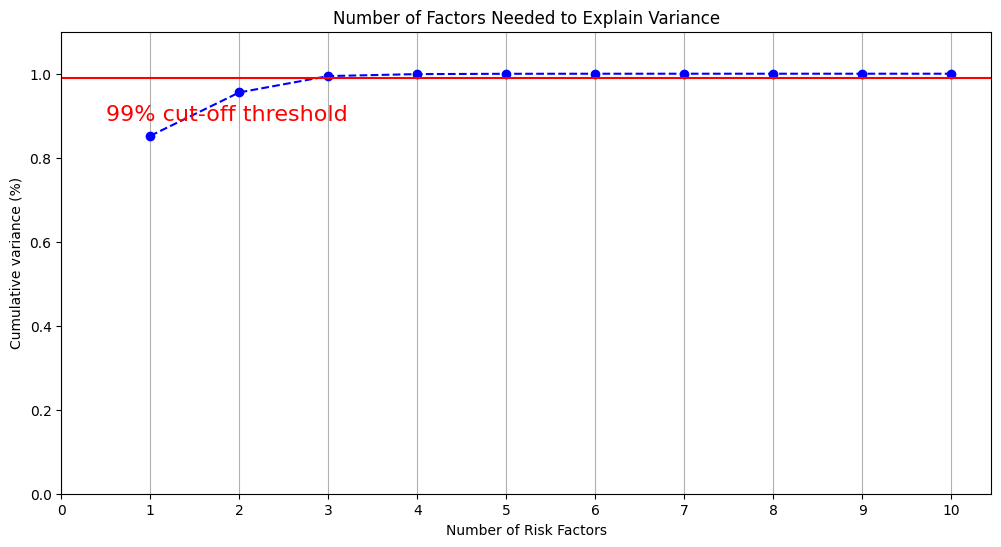

In [1510]:
from sklearn.decomposition import PCA
pca = PCA().fit(scaledYields.T)

# matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (12,6)

fig, ax = plt.subplots()
xi = np.arange(1, 11, step=1)
y = np.cumsum(pca.explained_variance_ratio_)[0:10]

plt.ylim(0.0,1.1)
plt.plot(xi, y, marker='o', linestyle='--', color='b')

plt.xlabel('Number of Risk Factors')
plt.xticks(np.arange(0, 11, step=1)) #change from 0-based array index to 1-based human-readable label
plt.ylabel('Cumulative variance (%)')
plt.title('Number of Factors Needed to Explain Variance')

plt.axhline(y=0.99, color='r', linestyle='-')
plt.text(0.5, 0.89, '99% cut-off threshold', color = 'red', fontsize=16)

ax.grid(axis='x')
plt.show()

One can infer from the plot that 4 components may suffice to explain over 99% of the variance in data. But in fact Adrian, Crump and Moench decided to incorporate 5 factors in the model, and so wil we in our model.

In their paper, Adrian, Crump, and Moench (2013) provide some justification for their choice of 5 factors in the ACM model.They note that prior research had suggested that 3 factors were sufficient to explain the dynamics of the term structure of interest rates, but that more recent studies had found evidence of additional factors. They cite empirical studies that suggest that including more factors can improve the model's ability to explain the term structure of interest rates and forecast future changes.

The authors also note that the choice of 5 factors was influenced by practical considerations, such as the need to balance the trade-off between model complexity and accuracy. They state that **"adding too many factors can lead to overfitting and instability, while too few factors can result in a poor fit to the data."**

In later part of our research, we will explore the possible consequences when less than 5 factors are incorporated in the model.

In [1511]:
X = yieldPCs[:, 0:K].T
pd.DataFrame(X)

,0,1,2,3,4,5,6,7,8,9,...,733,734,735,736,737,738,739,740,741,742
0,0.607077,0.593167,0.555737,0.598744,0.606917,0.589888,0.570925,0.538187,0.599443,0.633146,...,0.874711,0.696869,0.453436,0.369833,0.477872,0.431738,0.532706,0.379688,0.541592,0.571883
1,-0.266645,0.049919,-0.156347,-0.207748,-0.154738,-0.265540,-0.404608,-0.269716,-0.374256,-0.256334,...,-1.469086,-1.325595,-1.349326,-1.380914,-2.044984,-1.889099,-2.253075,-1.870194,-2.133797,-2.227149
2,0.826767,1.069951,0.801900,1.104938,0.918496,0.876462,0.989880,1.262794,0.870626,0.694197,...,0.909252,1.189609,1.265463,0.997635,0.435381,0.408292,0.095669,1.541035,-0.104986,-0.181220
3,-1.151464,-1.150391,-1.192269,-1.112915,-0.897556,-1.027808,-1.200439,-1.174431,-0.783352,-0.635628,...,-0.388100,-0.794906,-0.785783,-0.043895,0.216858,0.191303,0.673046,0.630857,0.706321,0.835226
4,0.748415,0.480257,0.810790,0.334387,0.485260,1.336875,1.692814,0.253659,0.444046,0.503653,...,-0.286275,-0.087612,-0.415590,-0.925573,-0.302616,-0.235139,-0.380314,-2.335659,0.176232,0.115111


These are the 5 principle components, also known as risk factors in the ACM model.

# ACM Model Estimation: 3-Step Procedure

The ACM model suggests that the return generating process for log excess holding period follows the flowing dynamic:

$$
\begin{equation}
rx = \beta'(\lambda_0 i'_T + \lambda_1X\_) - \frac{1}{2}(B^*vec(\Sigma) + \sigma^2 i_N)i'_T + \beta'V + E  
\tag{*}
\end{equation}$$

Dimensions:

$$
rx: N \times T\\
\beta: K \times N\\
i_T: T \times 1\\
i_N: N \times 1\\
X\_: K \times T\\
B^*: N \times K ^2\\
V: K \times T\\
E: N \times T
$$

## STEP 1

ACM model assumes that the dynamics of a $K \times 1$ vector of factors $X_t$ evolve according to the following vector autoregression:

$$ X_{t+1} = \mu + \Phi X_t + v_{t+1}$$

Dimensions of the values(per a specific t):
$$
X_{t+1}: K \times 1\\
X_{t}: K \times 1\\
\mu : K \times 1\\
\Phi : K \times K\\
v_{t+1} : K \times 1
$$

Dimensions of the values:

$$ X_{lhs}: K \times T\\
X_{rhs}: （K + 1）\times T\\
\mu : K \times T\\
\Phi : K \times K\\
V : K \times T
$$

As per code in 'Data Parsing':
 $$T = 742\\
 K = 5$$

In [1512]:
X_lhs = X[:, 1:]  #X_t+1. Left hand side of VAR. # X_lhs: K * T 
X_rhs = np.vstack((np.ones((1, t)), X[:, 0:-1])) #X_t and a constant. # X_rhs: K * T 
var_coeffs = (X_lhs @ np.linalg.pinv(X_rhs)) 
# please note that np.linalg.pinv(X) returns the pseudo inverse of X
# when X is row full rank, the pseudo inverse is equal to X'(XX')^(-1)
mu = var_coeffs[:, [0]] # K * 1
phi = var_coeffs[:, 1:] # K * K 
v = X_lhs - var_coeffs @ X_rhs # K * T 

In [1513]:
# substitute 


In [1514]:
pd.DataFrame(X_lhs)

,0,1,2,3,4,5,6,7,8,9,...,732,733,734,735,736,737,738,739,740,741
0,0.593167,0.555737,0.598744,0.606917,0.589888,0.570925,0.538187,0.599443,0.633146,0.640406,...,0.874711,0.696869,0.453436,0.369833,0.477872,0.431738,0.532706,0.379688,0.541592,0.571883
1,0.049919,-0.156347,-0.207748,-0.154738,-0.265540,-0.404608,-0.269716,-0.374256,-0.256334,-0.372468,...,-1.469086,-1.325595,-1.349326,-1.380914,-2.044984,-1.889099,-2.253075,-1.870194,-2.133797,-2.227149
2,1.069951,0.801900,1.104938,0.918496,0.876462,0.989880,1.262794,0.870626,0.694197,1.063968,...,0.909252,1.189609,1.265463,0.997635,0.435381,0.408292,0.095669,1.541035,-0.104986,-0.181220
3,-1.150391,-1.192269,-1.112915,-0.897556,-1.027808,-1.200439,-1.174431,-0.783352,-0.635628,-0.927919,...,-0.388100,-0.794906,-0.785783,-0.043895,0.216858,0.191303,0.673046,0.630857,0.706321,0.835226
4,0.480257,0.810790,0.334387,0.485260,1.336875,1.692814,0.253659,0.444046,0.503653,0.285394,...,-0.286275,-0.087612,-0.415590,-0.925573,-0.302616,-0.235139,-0.380314,-2.335659,0.176232,0.115111


ACM model assumes that the shocks $v_{t+1}$ conditionally follow a Gaussian distribution with variance-covariance matrix $\Sigma$:

$$ v_{t+1} | \{X_s\}^t_{s=0}\sim N(0, \Sigma) $$

ACM model stack $V_{t+1}$ into $\hat V$ and uses an estimator of the state
variable variance-covariance matrix as:

$$\hat\Sigma = \frac{\hat V \hat V'}{T} $$

Dimensions:

$$\hat \Sigma: K \times K\\
 $$

In [1515]:
Sigma = v @ v.T / t

## STEP 2

The second step of estimation regress excess returns on a constant, lagged pricing factors and contemporaneous
pricing factor innovations according to:

$$ rx = ai_T^{'} + \beta^{'} \hat V + cX_{-} + E$$

Dimensions:

$$rx: N\times T\\
i'_T: 1 \times T\\
\hat V: K \times T\\
X\_: K \times T\\
E: N \times T\\
a: N \times 1\\
\beta': N \times K\\
c: N \times K\\
$$

We Collect the regressors into the $(2K + 1) \times T$ matrix $\tilde{Z} =[i'_T, \hat V, X\_ ]$ 

The original equation becomes；

$$rx = [\tilde{a}, \tilde{\beta}', \tilde{c}] \tilde{Z} + E$$

Dimensions:

$$
rx: N \times T\\
[\tilde{a}, \tilde{\beta}', \tilde{c}]: N \times (2K + 1)\\ 
\tilde{Z}: (2K + 1) \times T \\
E: N \times T
$$

our estimators become:

$$[\tilde{a}, \tilde{\beta}', \tilde{c}] = rx \tilde{Z}' (\tilde{Z} \tilde{Z}')^{-1}$$

In our case 
$$N = 8\\
T = 742\\
K = 5$$

in the code we denote $[\tilde{a}, \tilde{\beta}', \tilde{c}]$  as $abc$ 

In [1516]:
# Use excess returns at these maturities to estimate the model.
rx_maturities = (6, 18, 24, 36, 48, 60, 84, 120) # 0.5y 1.5y 2y 3y 4y 5y 7y 10y

selected_rx = rx[:, [x - 2 for x in rx_maturities]].T  # Offset by 2 since index 0 is excess return on a 2m bond
N = selected_rx.shape[0]
Z = np.vstack((np.ones((1, t)), v, X[:, 0:-1]))  #Innovations and lagged X
abc = selected_rx @ np.linalg.pinv(Z)

a = abc[:, [0]]
beta = abc[:, 1:K+1].T
c = abc[:, K+1:]

We collect the residuals from this regression into the N × T matrix $\hat E$. 

We then estimate $\hat \sigma ^2 = \frac{trace(\hat E \hat E')}{NT} $



In [1517]:
E = selected_rx - abc @ Z
sigmasq_ret = np.sum(E * E) / E.size
sigmasq_ret

0.0030268811898770684

We construct $B^*$ from $\hat \beta$:

In [1518]:
BStar = np.squeeze(np.apply_along_axis(vec_quad_form, 1, beta.T))

## STEP 3

We estimate the price of risk parameters $\lambda_0$ and $\lambda_1$ via 
cross-sectional regression. We know from formula $(*)$ that 

$$a = \beta'\lambda_0 - \frac{1}{2}(B^*vec(\Sigma) + \sigma^2 i_N)$$

and $$c = \beta'\lambda_1$$

We use these expressions to obtain the following estimators for $\lambda_0$ and $\lambda_1$:
$$
\hat \lambda_0 = (\hat \beta \hat \beta')^{-1} \hat \beta(\hat a + \frac{1}{2}(\hat B ^* vec(\Sigma) + \hat \sigma ^2 i_N))
$$

and 

$$\hat \lambda_1 = (\hat \beta \hat \beta')^{-1} \hat \beta \hat c$$

Dimensions:

$$ B^*: N \times K^2\\
vec(\Sigma): K^2 \times 1\\
i_N: N \times 1\\
\hat \lambda_1: K \times K\\
\hat \lambda_0: K \times 1\\
\hat c: N \times K\\
\hat \beta: K \times N\\
\hat a: N \times 1\\
$$
We code the cross-sectional regressions as follows:

In [1519]:
lambda1 = np.linalg.pinv(beta.T) @ c
lambda0 = np.linalg.pinv(beta.T) @ (a + 1/2 * (BStar @ vec(Sigma) + sigmasq_ret))

# Run Bond Price Recursions

###### WHAT IS DELTA ??? 

In [1520]:
# Run bond pricing recursions
A = np.zeros((1, n_maturities))
B = np.zeros((K, n_maturities))

delta = rf.T @ np.linalg.pinv(np.vstack((np.ones((1, t)), X[:, 0:-1])))

delta0 = delta[[0], [0]]

delta1 = delta[[0], 1:]

In [1521]:
delta

array([[ 0.39020613, -0.2556206 , -0.0971139 , -0.09068481, -0.04052279,
        -0.00768326]])

here is an illistration of what vstack does:
a = np.array([[1], [2], [3]])

b = np.array([[4], [5], [6]])

np.vstack((a,b))

array(
  [[1],

  [2],

  [3],

  [4],

  [5],
  
  [6]])

In [1522]:
delta

array([[ 0.39020613, -0.2556206 , -0.0971139 , -0.09068481, -0.04052279,
        -0.00768326]])

In [1523]:
delta1

array([[-0.2556206 , -0.0971139 , -0.09068481, -0.04052279, -0.00768326]])

In [1524]:
A[0, 0] = 1/2 * sigmasq_ret - 1.0 * delta0
B[:, 0] = - delta1

In [1525]:
pd.DataFrame(A)

,0,1,2,3,4,5,6,7,8,9,...,110,111,112,113,114,115,116,117,118,119
0,-0.388693,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [1526]:
w, v = np.linalg.eig(phi-lambda1)
print(w)
# w /= np.abs(w[0])
w[0] = -1
# w[1:] /= 1.1
pml = (v @ np.diag(w) @ np.linalg.pinv(v)).real
print(pml)

[-1.47178266+0.j          0.99929254+0.j          0.97728715+0.j
  0.91376705+0.02828364j  0.91376705-0.02828364j]
[[ 1.00053382 -0.01292132 -0.016751   -0.0096282  -0.00184858]
 [ 0.03809829  0.92193478 -0.2530044  -0.16435642 -0.04250691]
 [ 0.12164022 -0.25125416 -0.19659756 -1.01808352 -0.30298607]
 [ 0.03159999 -0.16419931 -0.72955511  0.28497993 -0.29194238]
 [ 0.00944362 -0.08708899 -0.31410707 -0.27951839  0.79326282]]


In [1528]:
for i in range(0, n_maturities - 1):
    A[0, i+1] = A[0, i] + B[:, i].T @ (mu - lambda0) + 0.5 * (B[:, i].T @ Sigma @ B[:, i] + 1 * sigmasq_ret) - 1.*delta0
    # B[:, i+1] =  (phi - lambda1).T @ B[:, i] - delta1
    B[:, i+1] =  (pml).T @ B[:, i] - 1*delta1

In [1527]:
# print(mu-lambda0)
# w,v = np.linalg.eig(Sigma)
# Sigma = v @ np.diag(np.sqrt(w))

the plot trials have revealed that delta0 and delta1 is correct

In [1529]:
pd.DataFrame(B)

,0,1,2,3,4,5,6,7,8,9,...,110,111,112,113,114,115,116,117,118,119
0,0.255621,0.527462,0.788458,1.064754,1.329378,1.608557,1.875400,2.156204,2.424140,2.705566,...,26.413151,26.626831,26.826924,27.040013,27.239523,27.452036,27.650977,27.862927,28.061312,28.272713
1,0.097114,0.153236,0.241161,0.288129,0.366979,0.404990,0.475034,0.504412,0.566018,0.587170,...,-3.691686,-3.780491,-3.833050,-3.922148,-3.974992,-4.064367,-4.117477,-4.207110,-4.260471,-4.350346
2,0.090685,0.012027,0.094554,0.008837,0.085299,-0.005586,0.066515,-0.028002,0.041118,-0.055797,...,0.828269,0.770407,0.877637,0.820006,0.927460,0.870048,0.977715,0.920509,1.028378,0.971368
3,0.040523,-0.060824,-0.010898,-0.103393,-0.045176,-0.129944,-0.064560,-0.142713,-0.071256,-0.143861,...,-0.578519,-0.678393,-0.631759,-0.732025,-0.685773,-0.786412,-0.740523,-0.841516,-0.795971,-0.897299
4,0.007683,-0.030129,-0.009593,-0.037102,-0.008457,-0.029737,0.003534,-0.014478,0.020920,0.004082,...,0.226259,0.213202,0.252912,0.240174,0.280196,0.267762,0.308080,0.295934,0.336534,0.324662


In [1530]:
pd.DataFrame(A)

,0,1,2,3,4,5,6,7,8,9,...,110,111,112,113,114,115,116,117,118,119
0,-0.388693,-1.542119,-1.734236,-2.735311,-2.810088,-3.725382,-3.738984,-4.614737,-4.605361,-5.472241,...,-64.652181,-65.774247,-66.014537,-67.129493,-67.361561,-68.467256,-68.688905,-69.783094,-69.992032,-71.072381


In [1531]:
pd.DataFrame(X)

,0,1,2,3,4,5,6,7,8,9,...,733,734,735,736,737,738,739,740,741,742
0,0.607077,0.593167,0.555737,0.598744,0.606917,0.589888,0.570925,0.538187,0.599443,0.633146,...,0.874711,0.696869,0.453436,0.369833,0.477872,0.431738,0.532706,0.379688,0.541592,0.571883
1,-0.266645,0.049919,-0.156347,-0.207748,-0.154738,-0.265540,-0.404608,-0.269716,-0.374256,-0.256334,...,-1.469086,-1.325595,-1.349326,-1.380914,-2.044984,-1.889099,-2.253075,-1.870194,-2.133797,-2.227149
2,0.826767,1.069951,0.801900,1.104938,0.918496,0.876462,0.989880,1.262794,0.870626,0.694197,...,0.909252,1.189609,1.265463,0.997635,0.435381,0.408292,0.095669,1.541035,-0.104986,-0.181220
3,-1.151464,-1.150391,-1.192269,-1.112915,-0.897556,-1.027808,-1.200439,-1.174431,-0.783352,-0.635628,...,-0.388100,-0.794906,-0.785783,-0.043895,0.216858,0.191303,0.673046,0.630857,0.706321,0.835226
4,0.748415,0.480257,0.810790,0.334387,0.485260,1.336875,1.692814,0.253659,0.444046,0.503653,...,-0.286275,-0.087612,-0.415590,-0.925573,-0.302616,-0.235139,-0.380314,-2.335659,0.176232,0.115111


In [1532]:
pd.DataFrame(A.T)

,0
0,-0.388693
1,-1.542119
2,-1.734236
3,-2.735311
4,-2.810088
...,...
115,-68.467256
116,-68.688905
117,-69.783094
118,-69.992032


In [1533]:
C = np.array([[1] * 120] * 3 )
pd.DataFrame(C / ttm)

,0,1,2,3,4,5,6,7,8,9,...,110,111,112,113,114,115,116,117,118,119
0,12.0,6.0,4.0,3.0,2.4,2.0,1.714286,1.5,1.333333,1.2,...,0.108108,0.107143,0.106195,0.105263,0.104348,0.103448,0.102564,0.101695,0.10084,0.1
1,12.0,6.0,4.0,3.0,2.4,2.0,1.714286,1.5,1.333333,1.2,...,0.108108,0.107143,0.106195,0.105263,0.104348,0.103448,0.102564,0.101695,0.10084,0.1
2,12.0,6.0,4.0,3.0,2.4,2.0,1.714286,1.5,1.333333,1.2,...,0.108108,0.107143,0.106195,0.105263,0.104348,0.103448,0.102564,0.101695,0.10084,0.1


In [1534]:
# Construct fitted yields
# fittedLogPrices = (A.T + B.T @ X).T
fittedLogPrices = (B.T @ X).T
fittedYields = - fittedLogPrices / ttm

In [1538]:
fittedYields -= (fittedYields[0,:] - rawYields[0,:])

In [1539]:
pd.DataFrame(ttm)

,0,1,2,3,4,5,6,7,8,9,...,110,111,112,113,114,115,116,117,118,119
0,0.083333,0.166667,0.25,0.333333,0.416667,0.5,0.583333,0.666667,0.75,0.833333,...,9.25,9.333333,9.416667,9.5,9.583333,9.666667,9.75,9.833333,9.916667,10.0


In [1540]:
pd.DataFrame(fittedLogPrices)

,0,1,2,3,4,5,6,7,8,9,...,110,111,112,113,114,115,116,117,118,119
0,0.163351,0.336782,0.497893,0.668152,0.825393,0.991281,1.143823,1.304825,1.452414,1.608496,...,18.539452,18.750242,18.950405,19.161797,19.362540,19.574493,19.775777,19.988252,20.190039,20.402998
1,0.210575,0.388892,0.588823,0.756539,0.946036,1.103587,1.283272,1.431430,1.602187,1.741920,...,17.143516,17.312545,17.508763,17.678279,17.874968,18.044936,18.242061,18.412450,18.609979,18.780757
2,0.157510,0.326906,0.481508,0.646951,0.796814,0.956953,1.101135,1.255376,1.393578,1.541867,...,16.793330,16.988055,17.170055,17.365410,17.548019,17.743962,17.927139,18.123632,18.307340,18.504344
3,0.190548,0.354887,0.535380,0.690083,0.861417,1.007479,1.170724,1.309269,1.465580,1.597777,...,18.216346,18.405586,18.616170,18.805916,19.016988,19.207204,19.418729,19.609381,19.821324,20.012378
4,0.190764,0.347433,0.533186,0.684547,0.864827,1.010665,1.185462,1.325933,1.495541,1.631052,...,17.991645,18.165233,18.370709,18.544703,18.750569,18.924939,19.131166,19.305882,19.512441,19.687475
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
738,-0.030125,-0.061393,-0.076393,-0.092055,-0.091144,-0.090738,-0.073728,-0.057299,-0.024432,0.007613,...,18.551829,18.772183,19.001225,19.221824,19.451096,19.671914,19.901394,20.122406,20.352068,20.573252
739,-0.049607,-0.092598,-0.117978,-0.136607,-0.137694,-0.132269,-0.109683,-0.081082,-0.035908,0.014618,...,21.991901,22.238024,22.489577,22.735684,22.987213,23.233290,23.484781,23.730812,23.982252,24.228225
740,0.062801,-0.035775,0.009591,-0.099533,-0.058873,-0.167788,-0.122818,-0.224032,-0.168596,-0.257124,...,17.315893,17.441430,17.717611,17.842838,18.118708,18.243624,18.519185,18.643793,18.919047,19.043348
741,-0.048324,-0.090839,-0.106881,-0.118641,-0.105434,-0.089422,-0.049885,-0.008944,0.054167,0.117376,...,21.726748,21.965198,22.214396,22.452907,22.702158,22.940713,23.190000,23.428581,23.677886,23.916477


# Plotting

<Figure size 1728x864 with 0 Axes>

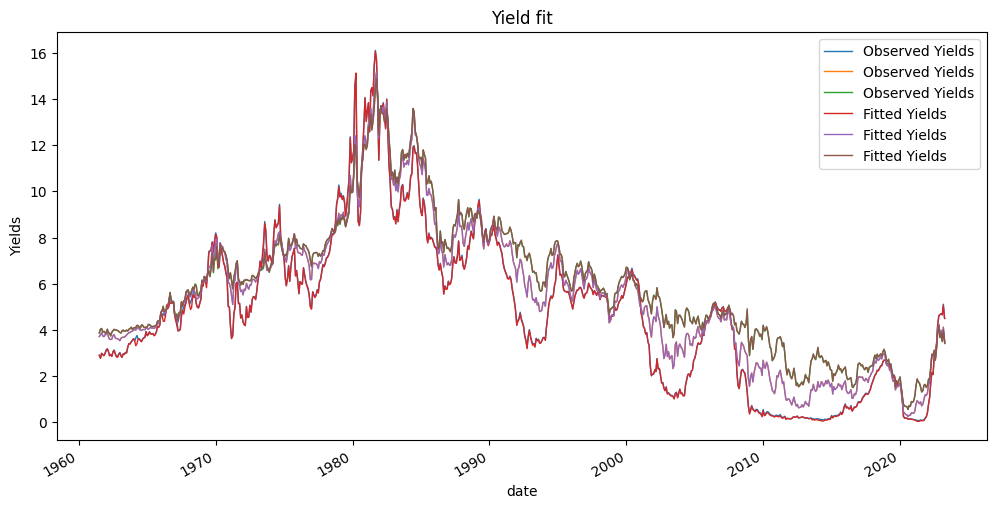

In [1541]:
# Plot fit for 1y, 5y, 10y bonds
plt.interactive(True)
plt.figure(dpi=144)
fig, axes = plt.subplots()
axes.plot(plot_dates, rawYields[:, (11,59, 119)], label="Observed Yields", linewidth=1)
axes.plot(plot_dates, fittedYields[:, (11,59, 119)], label = "Fitted Yields", linewidth=1)
axes.xaxis.set_major_locator(mdates.AutoDateLocator())
axes.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
fig.autofmt_xdate()
axes.set_xlabel("date")
axes.set_ylabel("Yields")
axes.set_title("Yield fit")
axes.legend()
plt.show()